# Prepare
## Dataset loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm

train_raw = pd.read_excel('/home/competition/data/data/ai_competition_train.xlsx')
test_raw = pd.read_excel('/home/competition/data/data/ai_competition_test.xlsx')

train = np.array(train_raw['flux'])
test = np.array(test_raw['flux'])

print(train.shape, test.shape)

#windows shift
INPUT_DAYS = 60


2023-10-15 13:44:53.717567: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-15 13:44:53.720988: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-15 13:44:53.763717: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-15 13:44:53.765720: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 13:44:54.677921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

(5479,) (60,)


### NaN to zeros

In [2]:
def nan_to_zero(_input):        
    print("1. NaN 값의 개수:", np.sum(np.isnan(_input)), "개는 0으로 대체되었음.")
    nan_indices = np.isnan(train)
    _mask = np.zeros(len(train))
    train[nan_indices] = _mask[nan_indices]
    return train


### Cut zeros

In [3]:
def cut_zeros(_data):
    print("2. before cut:", _data.shape)
    _data_cut = _data[_data != 0]
    print("3. after cut:", _data_cut.shape)
    return _data_cut

### Make dataset windows shift

In [4]:
def make_dataset_windowsshift(_input, window_size=INPUT_DAYS):
    assert min(_input) > 0
    # subtract mean
    _data = _input.copy()
    
    _data_submean = _data - np.mean(_data)
    
    train_x = np.zeros([INPUT_DAYS, 1])
    train_y = np.zeros([1, 1])

    #print("x and y shape :", train_x.shape, train_y.shape)
    for i in range(len(_data_submean) - INPUT_DAYS - 1):
        train_x = np.concatenate(
            (train_x, _data_submean[i:i+INPUT_DAYS, np.newaxis]), axis=1)
        train_y = np.concatenate(
            (train_y, _data_submean[np.newaxis, i+INPUT_DAYS+1, np.newaxis]), axis=1)

    #print("x and y shape :", train_x.shape, train_y.shape)
    train_x = train_x[:, 1:]
    train_y = train_y[:, 1:]
    train_x = train_x.T
    train_y = train_y.T
    print("dataset shape : ", train_x.shape, train_y.shape)
    
    return train_x, train_y


### prediction

In [14]:
def prediction(_input, _model):
    _copy = _input.copy()

    # 아무런 전처리 필요없음.

    _copy_mean = np.mean(_copy)
    _result = _copy - _copy_mean

    # sub mean은 학습할때만 해주면 됨.
    # training시의 sub mean은 make dataset에서 해줌.

    for i in tqdm(range(30)):
        _output = _model.predict(
            _result[np.newaxis, i:i+INPUT_DAYS, np.newaxis], verbose=0)
        _result = np.concatenate((_result, _output[0]), axis=0)

    # Subtract mean했던거 다시 더해주기
    _result = _result + _copy_mean
    _summit = _result[-30:]

    plt.figure()
    plt.plot(_result, label='output')
    plt.plot(test, label='input')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    return _summit


---

# Model

### Define model

In [6]:
loss_history = []


class LossHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss_history.append(logs['loss'])


loss_callback = LossHistory()


def create_lstm_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=80, input_shape=input_shape))
    model.add(keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['RootMeanSquaredError'])
    return model


## First training

In [7]:
input_shape = (INPUT_DAYS, 1)
first_lstm_model = create_lstm_model(input_shape)
first_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80)                26240     
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 26321 (102.82 KB)
Trainable params: 26321 (102.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1. NaN 값의 개수: 1251 개는 0으로 대체되었음.
2. before cut: (5479,)
3. after cut: (4228,)
dataset shape :  (4167, 60) (4167, 1)
Epoch 1/40
66/66 [==============================] - 4s 28ms/step - loss: 813.1809 - root_mean_squared_error: 28.5163
Epoch 2/40
66/66 [==============================] - 2s 27ms/step - loss: 620.6243 - root_mean_squared_error: 24.9123
Epoch 3/40
66/66 [==============================] - 2s 26ms/step - loss: 506.7628 - root_mean_squared_error: 22.5114
Epoch 4/40
66/66 [==============================] - 2s 26ms/step - loss: 431.0898 - root_mean_squared_error: 20.7627
Epoch 5/40
66/66 [==============================] - 2s 28ms/step - loss: 382.3304 - root_mean_squared_error: 19.5533
Epoch 6/40
66/66 [==============================] - 2s 28ms/step - loss: 348.1971 - root_mean_squared_error: 18.6600
Epoch 7/40
66/66 [==============================] - 2s 27ms/step - loss: 321.2209 - root_mean_squared_error: 17.9226
Epoch 8/40
66/66 [==============================] - 2s 27ms/step 

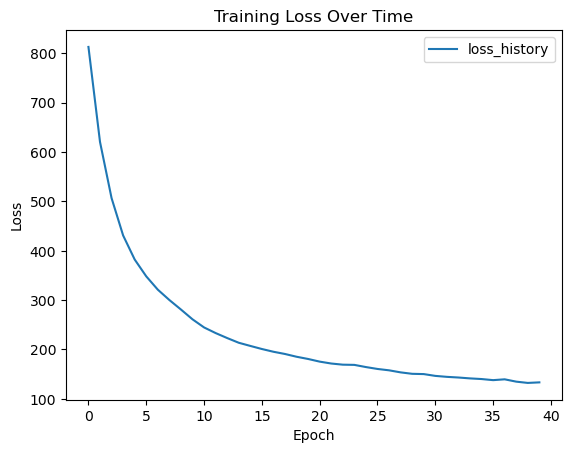

In [8]:
train_zeros = nan_to_zero(train)
train_cut = cut_zeros(train_zeros)
train_x, train_y = make_dataset_windowsshift(train_cut)

first_lstm_model.fit(train_x, train_y, epochs=40,
                     batch_size=64, callbacks=[loss_callback])


plt.plot(loss_history)
plt.title('Training Loss Over Time')
plt.legend(['loss_history', 'rmse_history'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


100%|██████████| 30/30 [00:01<00:00, 23.95it/s]


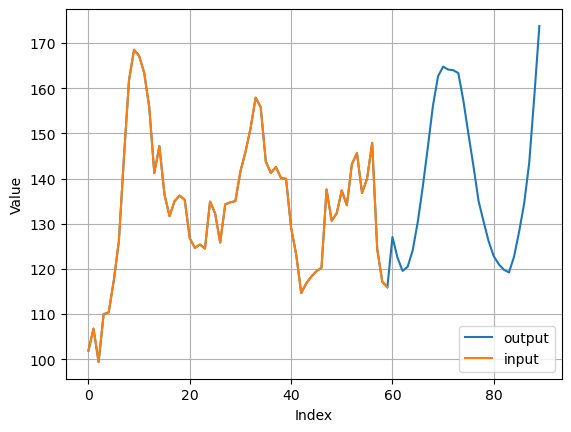

In [15]:
_tmp = prediction(test, first_lstm_model)

## Second training

- zero 다 삭제하고 비뚤어진 데이터셋으로 한 번 학습시킨 다음에
- 동일 모델로 결측값을 예측하고 
- 다시 학습 시키고
- 그것으로 최종 예측하는 2단계 프로세스

### interpolation

In [19]:
def interpolation(_input, _model):
    _copy = _input.copy()

    for i in tqdm(range(INPUT_DAYS, len(_copy))):
        if _copy[i] == 0:
            #print(i-INPUT_DAYS-1, i-1, 'i = ',i)
            _copy[i] = _model.predict(
                _copy[i-INPUT_DAYS-1:i-1].reshape(1, INPUT_DAYS, 1), verbose=0)
    
    return _copy



  0%|          | 0/5419 [00:00<?, ?it/s]

100%|██████████| 5419/5419 [00:51<00:00, 105.02it/s]


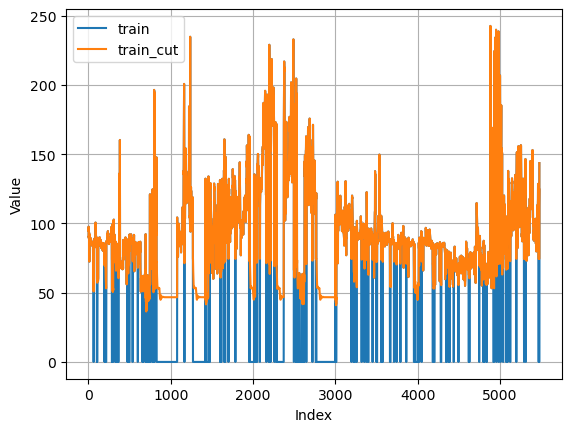

In [20]:
_interpolated = interpolation(train, first_lstm_model)

plt.figure()
plt.plot(train, label='train')
plt.plot(_interpolated, label='train_cut')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

### 이동평균선의 기울기가 0에 가까운 값들 모두 제거하기.
- 하이퍼파라미터 : 기울기, 이동평균선 설정 길이

(5479,)
(4992,)
delete ratio :  0.08888483299872241


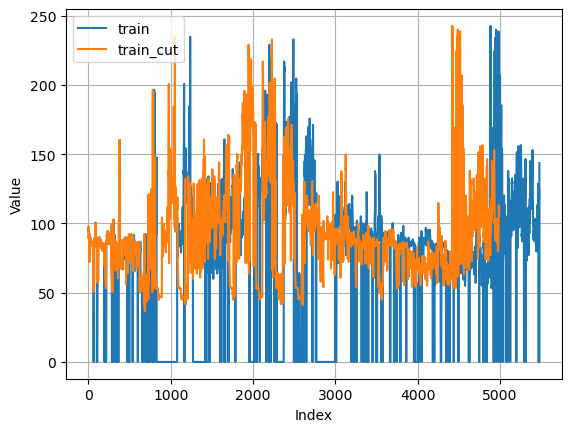

In [55]:

from scipy.signal import savgol_filter

print(_interpolated.shape)
_tmptmptmp = _interpolated.copy()



# 이동평균 계산 (예시로 3일 이동평균 사용)
window_size = 20
moving_average = np.convolve(_tmptmptmp, np.ones(
    window_size) / window_size, mode='valid')

# 기울기가 0에 가까운 값을 식별하여 제거
threshold = 0.01 # 기울기의 임계값 (조절 가능)
filtered_data = []
for i in range(len(moving_average)):
    if abs(np.gradient(moving_average)[i]) >= threshold:
        filtered_data.append(_tmptmptmp[i])

# 결과 출력
filtered_data = np.array(filtered_data)
print(filtered_data.shape)
print("delete ratio : ", 1 - len(filtered_data) / len(_tmptmptmp))
plt.figure()
plt.plot(train, label='train')
plt.plot(filtered_data, label='train_cut')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [57]:
# 2번째 학습    

_copy_train_x, _copy_train_y = make_dataset_windowsshift(filtered_data)

second_lstm_model = create_lstm_model(input_shape)
second_lstm_model.summary()
second_lstm_model.fit(_copy_train_x, _copy_train_y, epochs=40,
          batch_size=64, callbacks=[loss_callback])


dataset shape :  (4931, 60) (4931, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 80)                26240     
                                                                 
 dense_2 (Dense)             (None, 1)                 81        
                                                                 
Total params: 26321 (102.82 KB)
Trainable params: 26321 (102.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
78/78 [==============================] - 4s 28ms/step - loss: 950.0944 - root_mean_squared_error: 30.8236
Epoch 2/40
78/78 [==============================] - 2s 28ms/step - loss: 731.0325 - root_mean_squared_error: 27.0376
Epoch 3/40
78/78 [==============================] - 2s 28ms/step - loss: 597.4619 - root_mean_squared_error: 24.4430
Epoch 4/40
78/78 [=====

# Prediction

---

- input 60개로 61번째 예측
- 2번째 ~ 61번째로, 62번째 예측
- 90번째를 예측할 때 까지 반복하고, 61~90번째를 제출

100%|██████████| 30/30 [00:01<00:00, 18.03it/s]


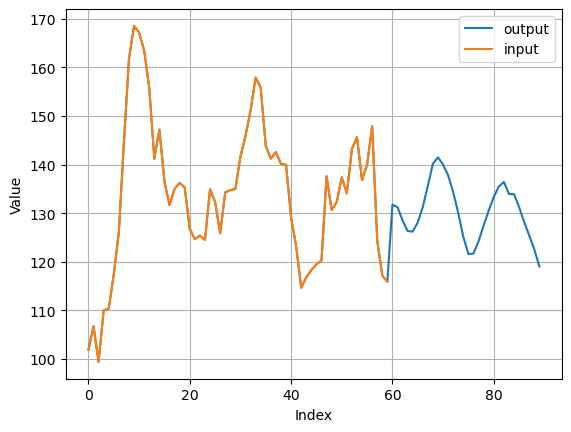

In [58]:
_final_result = prediction(test, second_lstm_model)

## output xlsx file 생성

In [62]:
import datetime

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
df = pd.DataFrame({'date': np.array(range(1, 31)), 'flux': _final_result})

# DataFrame을 엑셀 파일로 내보내기
file_name = f'/home/competition/data/data/dev/{current_time}_output_{loss_history[-1]}.xlsx'
df.to_excel(file_name, index=False)

model_name = f'/home/competition/data/data/dev/{current_time}_model_{loss_history[-1]}.h5'
second_lstm_model.save(model_name)


/home/competition/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
